# Парсер статей различных кодексов РФ

In [146]:
from bs4 import BeautifulSoup
import pathlib, re, pandas as pd

In [ ]:
import subprocess
import os

def read_file_text(path: pathlib.Path) -> str:
    """
    Reads .doc files in various formats and returns plain text.
    
    Supports:
    - HTML-based .doc files (uses BeautifulSoup)
    - Binary .doc files (uses antiword system utility)
    - Fallback text decoding for other formats
    
    Requirements:
    - antiword system utility (brew install antiword on macOS)
    - beautifulsoup4 Python package
    """
    data = path.read_bytes()

    if b'<html' in data.lower():
        # HTML-based .doc file
        soup = BeautifulSoup(data, 'html.parser')
        text = soup.get_text('\n')
    else:
        # Check if it's a real .doc file (binary Word format)
        if data.startswith(b'\xd0\xcf\x11\xe0') or b'Microsoft Word' in data:
            # Try to use antiword to extract text
            try:
                result = subprocess.run(['antiword', str(path)], 
                                      capture_output=True, text=True, encoding='utf-8')
                if result.returncode == 0:
                    text = result.stdout
                else:
                    # Fallback to binary reading
                    try:
                        text = data.decode('utf-8')
                    except UnicodeDecodeError:
                        text = data.decode('cp1251', errors='ignore')
            except (subprocess.SubprocessError, FileNotFoundError):
                # antiword not available, fallback to binary reading
                try:
                    text = data.decode('utf-8')
                except UnicodeDecodeError:
                    text = data.decode('cp1251', errors='ignore')
        else:
            # Regular text file
            try:
                text = data.decode('utf-8')
            except UnicodeDecodeError:
                text = data.decode('cp1251', errors='ignore')
    
    return text.replace('\u00A0', ' ')

In [148]:
# Regular Expression Patterns
re_section = re.compile(r'^\s*(?:\d+\s*\.\s*)?РАЗДЕЛ\s+([IVXLCDM]+)\.?\s*(.*)$',re.I)
re_chapter = re.compile(r'^ГЛАВА\s+((?:\d+|[IVXLCDM]+))\.?\s*(.*)$', re.I | re.M)
re_article = re.compile(r'^Статья\s+(\d+)\.?\s*(.*)$', re.I | re.M)
# Alternative pattern for articles without titles on the same line
re_article_simple = re.compile(r'^\s*Статья\s+(\d+)\s*$', re.I | re.M)

In [149]:
# Roman Numeral Converter
def roman_to_int(s):
    roman = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    prev = 0
    total = 0
    for char in reversed(s.upper()):
        value = roman[char]
        if value < prev:
            total -= value
        else:
            total += value
            prev = value
    return total

In [150]:
def parse_articles(path: pathlib.Path):

    def _save_article():
        """Saves the accumulated article in articles_meta"""
        article_end_char = sum(len(l) for l in lines[:i])
        rule_text = text[article_start_char:article_end_char]
        articles_meta.append({
            'file': path.name,
            'rule_number': rule_number,
            'rule_title': rule_title,
            'rule_text': rule_text,
            'section_title': current_section_title,
            'chapter_title': current_chapter_title,
            'start_char': article_start_char,
            'end_char': article_end_char,
            'text_length': len(rule_text)
        })

    def _peek_for_title(lines, start_idx):
        """
        Returns the first "meaningful" line after 'Article N'.
        Ignores empty, '1', '1.', '.', '2.', etc.
        """
        for ln in lines[start_idx:]:
            candidate = ln.strip()
            if candidate == '':
                continue
            if re.match(r'^[\d.]+$', candidate):
                continue
            # trim possible '1.' at the beginning of the line (our bugfix)
            candidate = re.sub(r'^\d+\s*\.?\s*', '', candidate).strip()
            if candidate:
                return candidate
        return ''
    
    def _peek_for_header(lines, start_idx):
        """
        Returns the first "content" line after the section/chapter/article title, ignoring:
        • empty lines; 
        • '1', '1.', 'n1', 'n2', '.'.
        """
        for ln in lines[start_idx:]:
            candidate = ln.strip()
            if not candidate:
                continue
            # n1 / n2 / 1 / 1. / .  => пропускаем
            if re.match(r'^(n?\d+|\\.)\\s*\\.?$', candidate, re.I):
                continue
            # убираем ведущие '1.' и т.п.
            candidate = re.sub(r'^\\d+\\s*\\.?\\s*', '', candidate).strip()
            if candidate:
                return candidate
        return ''


    text = read_file_text(path)
    lines = text.splitlines(keepends=True)

    articles_meta = []
    current_section_title = ''
    current_chapter_title = ''
    rule_number = None
    rule_title = ''
    article_start_char = None

    for i, raw_line in enumerate(lines):
        line = raw_line.strip()

        # --- раздел -------------------------------------
        m_sec = re_section.match(line)
        if m_sec:
            if rule_number is not None:
                _save_article()
                rule_number = None  # Reset rule_number after saving
            roman = m_sec.group(1).upper() 
            raw_title = m_sec.group(2).strip()
            current_section_title = (
                raw_title if raw_title else f"Раздел {roman}"
            )


        # --- глава --------------------------------------
        m_ch = re_chapter.match(line)
        if m_ch:
            if rule_number is not None:
                _save_article()
                rule_number = None  # Reset rule_number after saving

            chapter_raw = m_ch.group(1)
            try:
                chapter_num = int(chapter_raw)
            except ValueError:
                chapter_num = roman_to_int(chapter_raw)
            current_chapter_title = m_ch.group(2).strip()

            # if empty - we search further
            if current_chapter_title == '':
                current_chapter_title = _peek_for_header(lines, i + 1)

            # a backup option if you can't find anything at all
            if current_chapter_title == '':
                current_chapter_title = f'Глава {chapter_num}'


        # --- статья -------------------------------------
        m_art = re_article.match(line)
        m_art_simple = re_article_simple.match(line)
        
        if m_art:
            # close the previous one
            if rule_number is not None:
                _save_article()

            rule_number = int(m_art.group(1))
            rule_title = m_art.group(2).strip()

            # bugfix: if the title is empty, we search further
            if rule_title == '':
                rule_title = _peek_for_title(lines, i + 1)

            article_start_char = sum(len(l) for l in lines[:i])
            
        elif m_art_simple:
            # Handle articles without titles on the same line (like in Constitution)
            # close the previous one
            if rule_number is not None:
                _save_article()

            rule_number = int(m_art_simple.group(1))
            rule_title = _peek_for_title(lines, i + 1)

            article_start_char = sum(len(l) for l in lines[:i])

    if rule_number is not None:
        _save_article()

    return articles_meta

In [151]:
data_dir = pathlib.Path('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset')
files = sorted(data_dir.glob('*.doc'))  # Search for .doc files in directory

In [152]:
files

[PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Арбитражный процессуальный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Бюджетный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Водный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Воздушный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Градостроительный кодекс Российской Федерации.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Гражданский кодекс Российской Федерации. Часть вторая.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/dataset/Гражданский кодекс Российской Федерации. Часть первая.doc'),
 PosixPath('/Users/theother_archee/CursorProjects/SmartClause/parser/d

In [153]:
all_articles = []
for f in files:
    all_articles.extend(parse_articles(f))

df = pd.DataFrame(all_articles)
print(df.head())

                                                file  rule_number  \
0  Арбитражный процессуальный кодекс Российско...            1   
1  Арбитражный процессуальный кодекс Российско...            2   
2  Арбитражный процессуальный кодекс Российско...            3   
3  Арбитражный процессуальный кодекс Российско...            4   
4  Арбитражный процессуальный кодекс Российско...            5   

                                          rule_title  \
0       Осуществление правосудия арбитражными судами   
1        Задачи судопроизводства в арбитражных судах   
2  Законодательство о судопроизводстве в арбитраж...   
3               Право на обращение в арбитражный суд   
4              Независимость судей арбитражных судов   

                                           rule_text    section_title  \
0  Статья 1. Осуществление правосудия арбитражным...  ОБЩИЕ ПОЛОЖЕНИЯ   
1  Статья 2. Задачи судопроизводства в арбитражны...  ОБЩИЕ ПОЛОЖЕНИЯ   
2  Статья 3. Законодательство

## Check if data was parsed correctly

In [154]:
print("Shape: ", df.shape)
print("Columns: ", df.columns)

Shape:  (7781, 9)
Columns:  Index(['file', 'rule_number', 'rule_title', 'rule_text', 'section_title',
       'chapter_title', 'start_char', 'end_char', 'text_length'],
      dtype='object')


In [155]:
for col in df.columns:
    print(f"Уникальные значения в столбце '{col}':")
    print(df[col].unique())
    print("-" * 40)


Уникальные значения в столбце 'file':
['Арбитражный процессуальный кодекс Российской Федерации.doc'
 'Бюджетный кодекс Российской Федерации.doc'
 'Водный кодекс Российской Федерации.doc'
 'Воздушный кодекс Российской Федерации.doc'
 'Градостроительный кодекс Российской Федерации.doc'
 'Гражданский кодекс Российской Федерации. Часть вторая.doc'
 'Гражданский кодекс Российской Федерации. Часть первая.doc'
 'Гражданский кодекс Российской Федерации. Часть третья.doc'
 'Гражданский кодекс Российской Федерации. Часть четвертая.doc'
 'Гражданский процессуальный кодекс Российской Федерации.doc'
 'Жилищный кодекс Российской Федерации.doc'
 'Закон Российской Федерации о поправке к Конституции Российской Федерации от 14.03.2020 1-ФКЗ О совершенствовании регулирования отдельных вопросов организации и функционирования публичной власти.doc'
 'Земельный кодекс Российской Федерации.doc'
 'Кодекс административного судопроизводства Российской Федерации.doc'
 

In [172]:
# Checking for empty or NaN lines
print(df.isnull().sum())

for col in df.columns:
    num_empty = (df[col].astype(str).str.strip() == '').sum()
    print(f"Пустых строк в '{col}': {num_empty}")


rule_id          0
file             0
rule_number      0
rule_title       0
rule_text        0
section_title    0
chapter_title    0
start_char       0
end_char         0
text_length      0
dtype: int64
Пустых строк в 'rule_id': 0
Пустых строк в 'file': 0
Пустых строк в 'rule_number': 0
Пустых строк в 'rule_title': 0
Пустых строк в 'rule_text': 0
Пустых строк в 'section_title': 0
Пустых строк в 'chapter_title': 0
Пустых строк в 'start_char': 0
Пустых строк в 'end_char': 0
Пустых строк в 'text_length': 0


In [157]:
# empty_titles = df[df['chapter_title'].astype(str).str.strip() == '']
# print(empty_titles[['file', 'rule_title', 'rule_text', 'section_title']].iloc[:5])

In [158]:
# counts = df[df['chapter_title'].astype(str).str.strip() == ''].groupby('file').size()
# print(counts)


In [159]:
# Let's calculate the average line length for each column
str_cols = df.select_dtypes(include=['object']).columns
avg_str_lengths = df[str_cols].apply(lambda col: col.astype(str).str.len().mean())

print(avg_str_lengths)

file               57.329906
rule_title         64.959003
rule_text        2065.661997
section_title      26.549030
chapter_title      38.664310
dtype: float64


In [160]:
df['file'].unique()

array(['Арбитражный процессуальный кодекс Российской Федерации.doc',
       'Бюджетный кодекс Российской Федерации.doc',
       'Водный кодекс Российской Федерации.doc',
       'Воздушный кодекс Российской Федерации.doc',
       'Градостроительный кодекс Российской Федерации.doc',
       'Гражданский кодекс Российской Федерации. Часть вторая.doc',
       'Гражданский кодекс Российской Федерации. Часть первая.doc',
       'Гражданский кодекс Российской Федерации. Часть третья.doc',
       'Гражданский кодекс Российской Федерации. Часть четвертая.doc',
       'Гражданский процессуальный кодекс Российской Федерации.doc',
       'Жилищный кодекс Российской Федерации.doc',
       'Закон Российской Федерации о поправке к Конституции Российской Федерации от 14.03.2020 1-ФКЗ О совершенствовании регулирования отдельных вопросов организации и функционирования публичной власти.doc',
       'Земельный кодекс Российской Федерации.doc',
       'Кодекс админ

In [161]:
df[df['file'] == 'Жилищный кодекс Российской Федерации.doc'].sort_values('text_length', ascending=False).head()

,file,rule_number,rule_title,rule_text,section_title,chapter_title,start_char,end_char,text_length
3669,Жилищный кодекс Российской Федерации.doc,161,Выбор способа управления многоквартирным домом...,Статья 161. Выбор способа управления многоквар...,Раздел VIII,Правовое положение членов товарищества,507732,538543,30811
3659,Жилищный кодекс Российской Федерации.doc,155,Внесение платы за жилое помещение и коммунальн...,Статья 155. Внесение платы за жилое помещение ...,Раздел VII,Правовое положение членов товарищества,421763,442598,20835
3522,Жилищный кодекс Российской Федерации.doc,47,. Общее собрание собственников помещений в мно...,Статья 47\n1\n. Общее собрание собственников п...,Раздел II,Общее имущество собственников помещений в мног...,188458,205687,17229
3664,Жилищный кодекс Российской Федерации.doc,157,. Предоставление коммунальных услуг ресурсосна...,Статья 157\n2\n. Предоставление коммунальных у...,Раздел VII,Правовое положение членов товарищества,472412,488357,15945
3504,Жилищный кодекс Российской Федерации.doc,32,. Обеспечение жилищных прав граждан при осущес...,Статья 32\n1\n. Обеспечение жилищных прав граж...,Раздел II,Права и обязанности собственника жилого помеще...,115970,131409,15439


In [162]:
print(len(df[df['file'] == 'Конституция Российской Федерации.doc']))
print(len(df[df['file'] == 'Конституция Российской Федерации.doc']['rule_text'].unique()))

print(len(df))
print(len(df['rule_text'].unique()))

print(df[df['file'] == 'Конституция Российской Федерации.doc']['rule_text'].iloc[133])
print("--------------------------------")
print(df[df['file'] == 'Конституция Российской Федерации.doc']['rule_text'].iloc[132])
print("--------------------------------")
print(df[df['file'] == 'Конституция Российской Федерации.doc']['rule_text'].iloc[131])

137
137
7781
7781
                                 Статья 134

    Предложения о поправках и пересмотре положений  Конституции  Российской
Федерации могут вносить Президент  Российской  Федерации,  Совет  Федерации,
Государственная Дума, Правительство  Российской  Федерации,  законодательные
(представительные) органы субъектов Российской  Федерации,  а  также  группа
численностью не менее одной пятой  членов  Совета  Федерации  или  депутатов
Государственной Думы.


--------------------------------
                                 Статья 133

    Местное самоуправление в Российской Федерации гарантируется  правом  на
судебную  защиту,  на  компенсацию  дополнительных  расходов,  возникших   в
результате решений, принятых органами государственной  власти,  запретом  на
ограничение  прав  местного   самоуправления,   установленных   Конституцией
Российской Федерации и федеральными законами.


--------------------------------
                                 Статья 132

    1.   Органы   

## Processing of empty 'section_title'
- We have that because there is no sections (раздела) in some documents with codes (кодексами). We will replace these NaNs with "Отсутствует".

In [163]:
df['section_title'] = df['section_title'].replace(r'^\s*$', 'Отсутствует', regex=True)
df['chapter_title'] = df['chapter_title'].replace(r'^\s*$', 'Отсутствует', regex=True)

In [164]:
df[df['section_title'] == 'Отсутствует']

,file,rule_number,rule_title,rule_text,section_title,chapter_title,start_char,end_char,text_length
419,Бюджетный кодекс Российской Федерации.doc,1,"Правоотношения, регулируемые Бюджетным кодексо...","Статья 1. Правоотношения, регулируемые Бюджетн...",Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,7248,8449,1201
420,Бюджетный кодекс Российской Федерации.doc,2,Структура бюджетного законодательства Российск...,Статья 2. Структура бюджетного законодательств...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,8449,10123,1674
421,Бюджетный кодекс Российской Федерации.doc,3,"Нормативные правовые акты, регулирующие бюджет...","Статья 3. Нормативные правовые акты, регулирую...",Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,10123,11914,1791
422,Бюджетный кодекс Российской Федерации.doc,4,Бюджетное законодательство Российской Федераци...,Статья 4. Бюджетное законодательство Российско...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,11914,12490,576
423,Бюджетный кодекс Российской Федерации.doc,5,Действие закона (решения) о бюджете во времени,Статья 5. Действие закона (решения) о бюджете ...,Отсутствует,БЮДЖЕТНОЕ ЗАКОНОДАТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,12490,13040,550
...,...,...,...,...,...,...,...,...,...
7776,Федеральный конституционный закон от 04.10.2...,33,Адвокатура в Херсонской области,Статья 33. Адвокатура в Херсонской области\n \...,Отсутствует,Отсутствует,124798,125857,1059
7777,Федеральный конституционный закон от 04.10.2...,34,Архивные документы Херсонской области,Статья 34. Архивные документы Херсонской облас...,Отсутствует,Отсутствует,125857,126362,505
7778,Федеральный конституционный закон от 04.10.2...,35,Финансовая поддержка Херсонской области,Статья 35. Финансовая поддержка Херсонской обл...,Отсутствует,Отсутствует,126362,127383,1021
7779,Федеральный конституционный закон от 04.10.2...,36,Переходный период,Статья 36. Переходный период\n \nСо дня принят...,Отсутствует,Отсутствует,127383,127820,437


In [165]:
# Add a unique identifier rule_id
df = df.reset_index(drop=True).reset_index().rename(columns={"index": "rule_id"})

## Save the final CSV

In [166]:
csv_path = data_dir / 'dataset_codes_rf.csv'
df.to_csv(csv_path, index=False)
print(f'CSV saved: {csv_path}')

CSV saved: /Users/theother_archee/CursorProjects/SmartClause/parser/dataset/dataset_codes_rf.csv


# Exploration of final dataset

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

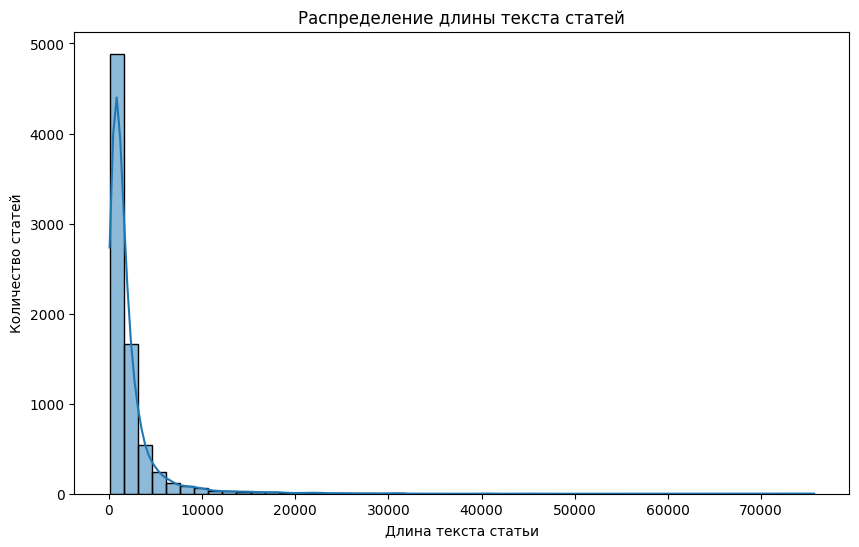

In [168]:
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Распределение длины текста статей')
plt.xlabel('Длина текста статьи')
plt.ylabel('Количество статей')
plt.show()

In [169]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]

print(f'Количество выбросов: {len(outliers)}')
display(outliers[['file', 'rule_number', 'rule_title', 'text_length']].sort_values('text_length', ascending=False))

Количество выбросов: 684


,file,rule_number,rule_title,text_length
1168,Градостроительный кодекс Российской Федерац...,51,Разрешение на строительство,75696
3715,Закон Российской Федерации о поправке к Конс...,1,Внести в,61440
1175,Градостроительный кодекс Российской Федерац...,55,Выдача разрешения на ввод объекта в эксплуатацию,55552
5454,Налоговый кодекс Российской Федерации. Част...,84,Порядок постановки на учет и снятия с учета ор...,45965
1164,Градостроительный кодекс Российской Федерац...,49,Экспертиза проектной документации и результато...,40678
...,...,...,...,...
3417,Гражданский процессуальный кодекс Российско...,411,Содержание ходатайства о принудительном исполн...,4665
6026,Трудовой кодекс Российской Федерации.doc,213,Государственная экспертиза условий труда,4662
5242,Лесной кодекс Российской Федерации.doc,63,. Особенности осуществления лесовосстановления...,4656
6726,Уголовно-процессуальный кодекс Российской Ф...,166,Протокол следственного действия,4654


In [170]:
df['text_length'].mean()

np.float64(2065.6619971726)

Constitution articles after fix: 137
Duplicate articles in Constitution: 0
No duplicates found!
Number of articles with duplicate text lengths: 9
Articles with same text length:
Length 223: 2 articles
  Article 53: Каждый имеет  право  на  возмещение  гос...
  Article 57: Каждый обязан платить законно установлен...
---
Length 300: 2 articles
  Article 12: В   Российской   Федерации   признается ...
  Article 73: Вне пределов  ведения  Российской  Федер...
---
Length 349: 2 articles
  Article 34: Каждый имеет право на свободное использо...
  Article 113: Председатель  Правительства  Российской ...
---
Length 375: 2 articles
  Article 54: Закон, устанавливающий или отягчающий от...
  Article 79: Российская   Федерация   может   участво...
---
Length 696: 2 articles
  Article 55: Перечисление в Конституции  Российской  ...
  Article 108: Федеральные  конституционные  законы   п...
---
